In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import covid19dh

from copy import deepcopy
from datetime import datetime
from epftoolbox.evaluation import MAE, sMAPE
from sklearn.metrics import mean_absolute_percentage_error
from epftoolbox.models import hyperparameter_optimizer
from epftoolbox.models import hyperparameter_optimizer_customized


from sklearn.preprocessing import StandardScaler

In [5]:
import epftoolbox
print(epftoolbox.__file__)

c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\__init__.py


In [6]:
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_lear.py
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_dnn.py


## Caricamento dati

In [7]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/Prezzi"

path_2020 = "/Anno2020/Anno 2020_12.xlsx"
path_2021 = "/Anno2021/Anno 2021_12.xlsx"
path_2022 = "/Anno2022/Anno 2022_12.xlsx"

path_2023 = "/Anno2023/Anno 2023_12.xlsx"
path_2024 = "/Anno2024/Anno 2024_08.xlsx"


In [8]:
prezzi2020_df = pd.read_excel(path+path_2020, sheet_name="Prezzi-Prices")
prezzi2021_df = pd.read_excel(path+path_2021, sheet_name="Prezzi-Prices")
prezzi2022_df = pd.read_excel(path+path_2022, sheet_name="Prezzi-Prices")

prezzi2023_df = pd.read_excel(path+path_2023, sheet_name="Prezzi-Prices")
prezzi2024_df = pd.read_excel(path+path_2024, sheet_name="Prezzi-Prices")

In [9]:
# Prezzi 20-22 
prezzi2020_df = prezzi2020_df.iloc[:, :3]
prezzi2021_df = prezzi2021_df.iloc[:, :3]
prezzi2022_df = prezzi2022_df.iloc[:, :3]

prezzi_20_21 = pd.concat([prezzi2020_df, prezzi2021_df])
train_df = pd.concat([prezzi_20_21, prezzi2022_df])

# Prezzi 23-24
prezzi2023_df = prezzi2023_df.iloc[:,:3]
prezzi2024_df = prezzi2024_df.iloc[:, :3]

test_df = pd.concat([prezzi2023_df, prezzi2024_df])




In [10]:
# Riformattiamo gli indici (per evitare duplicati)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
train_df.index.duplicated().sum(), test_df.index.duplicated().sum()


(0, 0)

In [12]:
train_df.iloc[0:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,1,41.88000
1,20200101,2,38.63858
2,20200101,3,36.55000
3,20200101,4,32.31772
4,20200101,5,30.85000
5,20200101,6,30.13762
6,20200101,7,30.16953
7,20200101,8,30.00000
8,20200101,9,30.65000
9,20200101,10,30.65000


In [13]:
# Riportiamo le ore a 0 - 23 piuttosto che 1-24
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: x - 1)
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: x - 1)

In [14]:
def compute_new_prices(input_df):

    ### GESTIONE CAMBIAMENTO ORA SOLARE

    # Calcoliamo le date in cui ci sono più di 24 valori
    wrong_dates = input_df['   Data/Date\n(YYYYMMDD)'][input_df['Ora\n/Hour'] > 23] 

    # Calcoliamo i prezzi delle 2/3 e facciamo una media
    prices_2 = input_df['PUN'].loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 2)]
    prices_3 = input_df['PUN'].loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 3)]

    new_prices = []
    for i, price in enumerate(list(prices_2)):
        new_prices.append((price + list(prices_3)[i])/2)

    # Sostituiamo i nuovi prezzi dove le date sono sbagliate (alle 2)
    input_df.loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 2), 'PUN'] = new_prices
    wrong_indexes = input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ) & (input_df['Ora\n/Hour'] == 3), :].index
    input_df.drop(index=wrong_indexes, inplace=True)

    for date in wrong_dates:
        input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date) , 'Ora\n/Hour'] = range(0, 24)

    # GESTIONE CAMBIAMENTO ORA LEGALE
    auxiliary_df = input_df.groupby(by = ['   Data/Date\n(YYYYMMDD)']).count()
    dates_list = list(auxiliary_df[auxiliary_df['Ora\n/Hour'] < 24].index)

    for date in dates_list:
        duplicated_row = input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date) & (input_df['Ora\n/Hour'] == 2)]
        input_df = pd.concat([input_df, duplicated_row]).sort_index()
        input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date), 'Ora\n/Hour'] = range(0, 24)
    

    return input_df

In [15]:
train_df = compute_new_prices(input_df=train_df)
test_df = compute_new_prices(input_df=test_df)

In [16]:
train_df['   Data/Date\n(YYYYMMDD)'] = train_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)

test_df['   Data/Date\n(YYYYMMDD)'] = test_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)


In [17]:
train_df.iloc[:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,00,41.88000
1,20200101,01,38.63858
2,20200101,02,36.55000
3,20200101,03,32.31772
4,20200101,04,30.85000
5,20200101,05,30.13762
6,20200101,06,30.16953
7,20200101,07,30.00000
8,20200101,08,30.65000
9,20200101,09,30.65000


In [18]:
pd.to_datetime('20200101 01' , format="%Y%m%d %H")

Timestamp('2020-01-01 01:00:00')

In [19]:
# Obiettivo -> riportare in datetime (anno/mese/giorno ora)
train_df['Date'] = train_df['   Data/Date\n(YYYYMMDD)'] + ' ' + train_df['Ora\n/Hour']

train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y%m%d %H")

test_df['Date'] = test_df['   Data/Date\n(YYYYMMDD)'] + ' ' + test_df['Ora\n/Hour']
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y%m%d %H")
 

In [20]:
train_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)
test_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)

## Caricamento dati Entso-E

In [21]:
# CARICA I DATI DI ENTSO - E PER GENERAZIONE
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_gen_2020 = "Generation\ENTSO_E_GEN_2020.xlsx"
path_gen_2021 = "Generation\ENTSO_E_GEN_2021.xlsx"
path_gen_2022 = "Generation\ENTSO_E_GEN_2022.xlsx"

path_gen_2023 = "Generation\ENTSO_E_GEN_2023.xlsx"
path_gen_2024 = "Generation\ENTSO_E_GEN_2024.xlsx"

In [22]:
gen_2020_df = pd.read_excel(path + path_gen_2020).iloc[:, :2]
gen_2021_df = pd.read_excel(path + path_gen_2021).iloc[:, :2]
gen_2022_df = pd.read_excel(path + path_gen_2022).iloc[:, :2]

gen_2023_df = pd.read_excel(path + path_gen_2023).iloc[:, :2]
gen_2024_df = pd.read_excel(path + path_gen_2024).iloc[:, :2] # Fino al 21/09

In [23]:
gen_2020_2021_df = pd.concat([gen_2020_df, gen_2021_df])
train_gen_df = pd.concat([gen_2020_2021_df, gen_2022_df])

test_gen_df = pd.concat([gen_2023_df, gen_2024_df])

In [24]:
# Riformattiamo gli indici (per evitare duplicati)
train_gen_df.reset_index(drop=True, inplace=True)
test_gen_df.reset_index(drop=True, inplace=True)

In [25]:
train_gen_df['Date'] = pd.to_datetime(train_gen_df['MTU'], format="%d.%m.%Y %H:%M ")
test_gen_df['Date'] = pd.to_datetime(test_gen_df['MTU'], format="%d.%m.%Y %H:%M ")

In [26]:
train_gen_df.drop(columns='MTU', inplace=True)
test_gen_df.drop(columns='MTU', inplace=True)

In [27]:
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_gen_df.drop_duplicates('Date', inplace=True), test_gen_df.drop_duplicates("Date", inplace=True)
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() 

(0, 0)

In [28]:
# CARICA I DATI DI ENTSO - E PER IL CARICO
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_load_2020 = "Load\ENTSO_E_LOAD_2020.xlsx"
path_load_2021 = "Load\ENTSO_E_LOAD_2021.xlsx"
path_load_2022 = "Load\ENTSO_E_LOAD_2022.xlsx"

path_load_2023 = "Load\ENTSO_E_LOAD_2023.xlsx"
path_load_2024 = "Load\ENTSO_E_LOAD_2024.xlsx"

In [29]:
load_2020_df = pd.read_excel(path + path_load_2020).iloc[:, :2]
load_2021_df = pd.read_excel(path + path_load_2021).iloc[:, :2]
load_2022_df = pd.read_excel(path + path_load_2022).iloc[:, :2]


load_2023_df = pd.read_excel(path + path_load_2023).iloc[:, :2]
load_2024_df = pd.read_excel(path + path_load_2024).iloc[:, :2] # Fino al 21/09

In [30]:
load_2020_2021_df = pd.concat([load_2020_df, load_2021_df])
train_load_df = pd.concat([load_2020_2021_df, load_2022_df])

test_load_df = pd.concat([load_2023_df, load_2024_df])

In [31]:
# Riformattiamo gli indici (per evitare duplicati)
train_load_df.reset_index(drop=True, inplace=True)
test_load_df.reset_index(drop=True, inplace=True)

In [32]:
train_load_df['Date'] = pd.to_datetime(train_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")
test_load_df['Date'] = pd.to_datetime(test_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")

In [33]:
train_load_df.drop(columns='Time (CET/CEST)', inplace=True)
test_load_df.drop(columns='Time (CET/CEST)', inplace=True)

In [34]:
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_load_df.drop_duplicates('Date', inplace=True), test_load_df.drop_duplicates("Date", inplace=True)
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() 

(0, 0)

## CREAZIONE DATASET COMPLETO

In [35]:
train_prices_df = deepcopy(train_df)
test_prices_df = deepcopy(test_df)

In [36]:
combined_train_df = pd.merge(left=train_prices_df, right=train_gen_df, on='Date', how='inner')
train_df = pd.merge(left=combined_train_df, right=train_load_df, on='Date', how='inner')

combined_test_df = pd.merge(left=test_prices_df, right=test_gen_df, on='Date', how='inner')
test_df = pd.merge(left=combined_test_df, right=test_load_df, on='Date', how='inner')

In [37]:
train_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)
test_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)

In [38]:
## Imputazione prima feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = train_df['Date'][train_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(train_df['Exogenous 1'].loc[(train_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = train_df['Date'][train_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(train_df['Exogenous 2'].loc[(train_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]


## Imputazione prima feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = test_df['Date'][test_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(test_df['Exogenous 1'].loc[(test_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = test_df['Date'][test_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(test_df['Exogenous 2'].loc[(test_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]

In [39]:
train_df = train_df.set_index('Date').sort_index()
test_df = test_df.set_index('Date').sort_index()


## Pre - processing

In [772]:
# Check indice iniziale
if train_df.index[0].hour != 0 or test_df.index[0].hour != 0:
    print('Problem with the index')

In [773]:
# Numero di variabili esogene (tutte tranne il prezzo)
n_exogenous_inputs = len(train_df.columns) - 1

In [774]:
# Features: 96 prices + n_exogenous * (24 * 3 exogeneous) + 7 weekday dummies
# Price lags: D-1, D-2, D-3, D-7
# Exogeneous inputs lags: D, D-1, D-7
# feriali/festivi
# festività/non festività

n_features = 96 + 6 + n_exogenous_inputs * 72

In [775]:
# Dato che compare il lag D-7 dobbiamo scartare almeno la prima settimana

indexTrain = train_df.loc[train_df.index[0] + pd.Timedelta(weeks=1):].index

In [776]:
indexTrain

DatetimeIndex(['2020-01-08 00:00:00', '2020-01-08 01:00:00',
               '2020-01-08 02:00:00', '2020-01-08 03:00:00',
               '2020-01-08 04:00:00', '2020-01-08 05:00:00',
               '2020-01-08 06:00:00', '2020-01-08 07:00:00',
               '2020-01-08 08:00:00', '2020-01-08 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=26136, freq=None)

In [777]:
# Se impostato su None prende tutti i valori possibili per la previsione, in caso contrario solo i valori da predire per un giorno specifico
date_test = None

if date_test is None:
    indexTest = test_df.loc[test_df.index[0] + pd.Timedelta(weeks=1):].index
else:
    indexTest = test_df.loc[date_test:date_test + pd.Timedelta(hours=23)].index

In [778]:
# Seleziono un timestamp ogni 24 -> un valore giornaliero
predDatesTrain = indexTrain.round('1h')[::24]
predDatesTest = indexTest.round('1h')[::24]

In [779]:
# Creiamo due datasets con tante colonne quante ore del giorno

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
for hour in range(24):
    indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
    indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

In [780]:
# Preallocamento della memoria
X_train = np.zeros([indexTrain.shape[0], n_features])
X_test = np.zeros([indexTest.shape[0], n_features])
Y_train = np.zeros([indexTrain.shape[0], 24])

In [781]:
feature_index = 0

In [782]:
# Aggiungere i prezzi storici nei giorni D-1, D-2, D-3 e D-7


for hour in range(24):
    # Lag
    for past_day in [1, 2, 3, 7]:

        # definiamo gli indici temporali utilizzando dataframes di appoggio
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)]) - pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24 * past_day)

        # Prezzi storici nei giorni passati all'ora h
        X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Price']
        X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Price']
        feature_index += 1

In [783]:
# Variabili esogene nei giorni D, D-1,  D-7

for hour in range(24):
    for past_day in [1, 7]:
        
        for exog in range(1, n_exogenous_inputs + 1):

            # Definying the corresponding past time indexs using the auxiliary dataframses 
            pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)
            pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)

            # Including the exogenous input at day D-past_day and hour "h" 
            X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
            X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Exogenous ' + str(exog)]
            feature_index += 1

    # For each of the exogenous inputs we include feature if feature selection indicates it
    for exog in range(1, n_exogenous_inputs + 1):
        
        # Definying the corresponding future time indexs using the auxiliary dataframses 
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Including the exogenous input at day D and hour "h" 
        X_train[:, feature_index] = train_df.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
        X_test[:, feature_index] = test_df.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
        feature_index += 1

In [784]:
# Aggiungiamo le holidays

holidays_it = holidays.IT(years = [2020, 2021, 2022, 2023, 2024])


holiday_dates = pd.to_datetime(list(holidays_it.keys()))


for holiday_index in range(2):
    if holiday_index == 0:
        X_train[~indexTrain.index.isin(holiday_dates), feature_index] = 1
        X_test[~indexTest.index.isin(holiday_dates), feature_index] = 1
        feature_index += 1
    else:
        X_train[indexTrain.index.isin(holiday_dates), feature_index] = 1
        X_test[indexTest.index.isin(holiday_dates), feature_index] = 1
        feature_index += 1


In [785]:
# Piccolo check per vedere gli indici associati a vacanze (puoi usarli in X_train[i, :] per visualizzare le features del giorno festivo)
# values = list(indexTrain.index.isin(holidays_it))

# for i, flag in enumerate(values):
#     if flag == True:
#         print(i)

In [786]:
# Ragionamento alla base: il consumo di elettricità variato e il prezzo stesso dipendono dal covid nel periodo di training -> 
# ciò con cui possiamo identificare il covid sono le restrizioni a stare a casa (sia 'leggere' che 'pesanti')

data, _ = covid19dh.covid19(country="Italy", verbose=False, level=1)

cols_to_retain = ["stay_home_restrictions"]

data["date"] = data["date"].dt.date
data.set_index("date", drop=True, inplace=True)
data = data[cols_to_retain]

for feature in data.columns:
    print(data[feature].unique())
    print("-" * 100)

# -2, 0, nan -> non ci sono restrizioni / 1, 2 -> restrizioni leggere, restrizioni pesanti

[-2.  2.  0.  1. nan]
----------------------------------------------------------------------------------------------------


In [787]:
covid_dates = pd.to_datetime(list(data[data['stay_home_restrictions'].isin([1, 2])].index))
non_covid_dates = pd.to_datetime(list(data[~ data['stay_home_restrictions'].isin([1, 2])].index))
covid_list = [covid_dates, non_covid_dates]

for covid_index in range(2):
    X_train[indexTrain.index.isin(covid_list[i]), feature_index] = 1
    X_test[indexTest.index.isin(covid_list[i]), feature_index] = 1
    feature_index += 1


In [788]:
# Aggiungiamo giorni feriali/festivi

working_days = [0, 1, 2, 3, 4]
non_working_days = [5, 6]
all_days = [working_days, non_working_days]

for dayofweek in range(2):

    X_train[indexTrain.index.dayofweek.isin(all_days[dayofweek]), feature_index] = 1
    X_test[indexTest.index.dayofweek.isin(all_days[dayofweek]), feature_index] = 1
    feature_index += 1

    # Estrazione dei valori predetti di y
    for hour in range(24):
        # Definizione degli indici di tempo all'ora h
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Estrazione dei valori di Y basandoci sugli indici di tempo
        Y_train[:, hour] = train_df.loc[futureIndexTrain, 'Price']

In [789]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer()
# imputer.fit(X_train)

# X_train = imputer.transform(X_train)
# X_test = imputer.transform(X_test)

In [790]:
# Il modello non ha più 247 features ma 246
feature_index

246

## Model definition / Training / Prediction

In [791]:
model = LEAR()

model.recalibrate(X_train, Y_train)

In [792]:
Y_test_pred = model.predict_days(X_test)

### Test/pred comparison

In [793]:
Y_test_pred

array([[173.24402623, 169.60202427, 160.26705474, ..., 181.77300243,
        179.93743362, 166.68994469],
       [143.95735844, 126.17676035, 134.31133618, ..., 165.0315138 ,
        164.59570906, 152.37537487],
       [122.5331584 ,  83.37294022,  95.31744383, ..., 155.88082436,
        149.6673055 , 139.74006969],
       ...,
       [134.7387118 , 125.89212656, 125.85209769, ..., 179.67034427,
        152.99298148, 145.31786251],
       [127.4766262 , 119.75976685, 121.1201991 , ..., 162.43439394,
        144.68095457, 136.54087881],
       [125.83180485, 120.87861601, 120.01023053, ..., 150.31473291,
        136.97651755, 127.05861871]])

In [794]:
excluded_days = test_df['Price'].shape[0] - (Y_test_pred.shape[0] * Y_test_pred.shape[1]) # 168 = 24 * 7 -> giorni esclusi


In [795]:
test_prices_list  = []

true_prices = test_df['Price'].iloc[excluded_days:]

In [796]:
for i in range(0, len(true_prices),24):
    test_prices_list.append(np.array(true_prices[i:24+i]))

In [797]:
Y_test = np.vstack(test_prices_list)

In [798]:
start_test_date = test_df.index[excluded_days] 
end_test_date = start_test_date + pd.Timedelta(days=X_test.shape[0]-1)
prediction_dates = pd.date_range(start=start_test_date, end=end_test_date, freq="D")

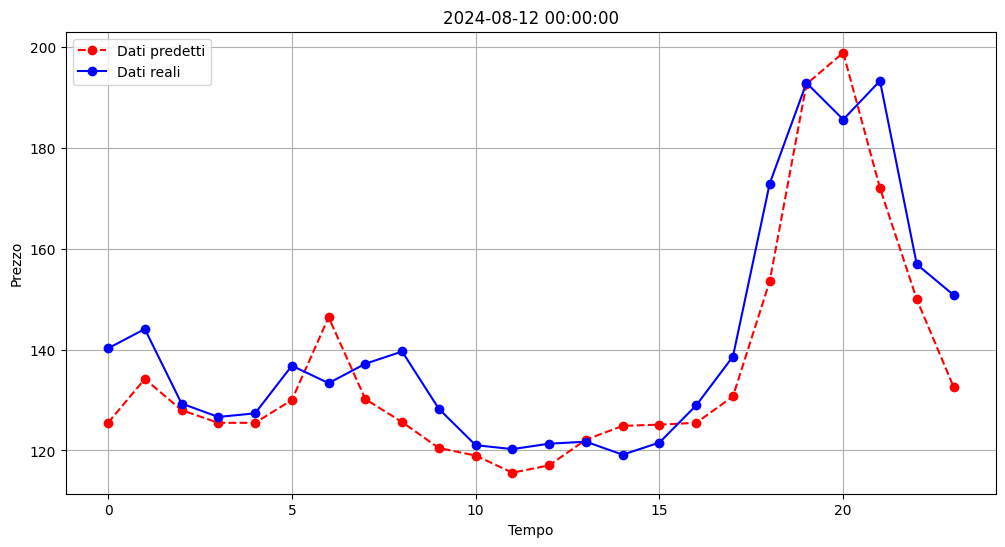

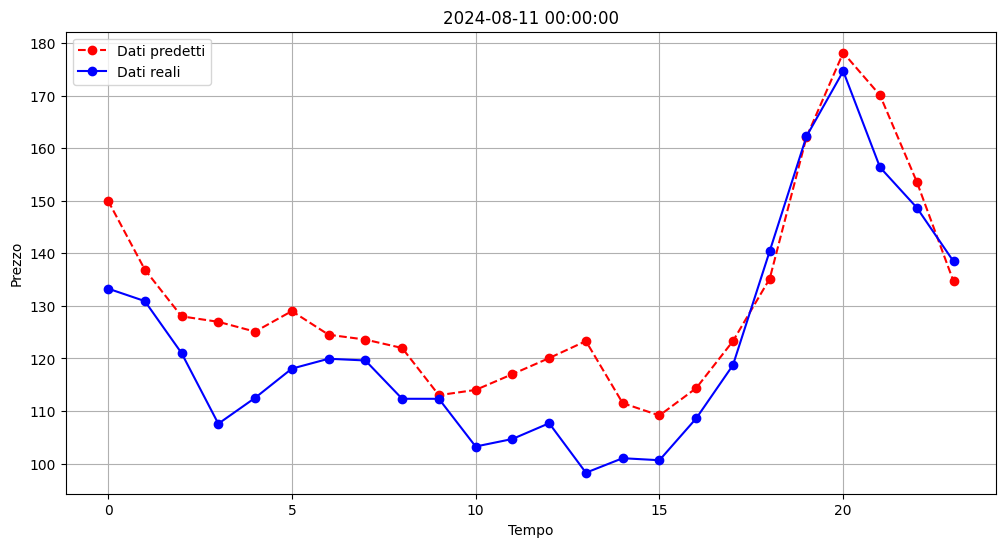

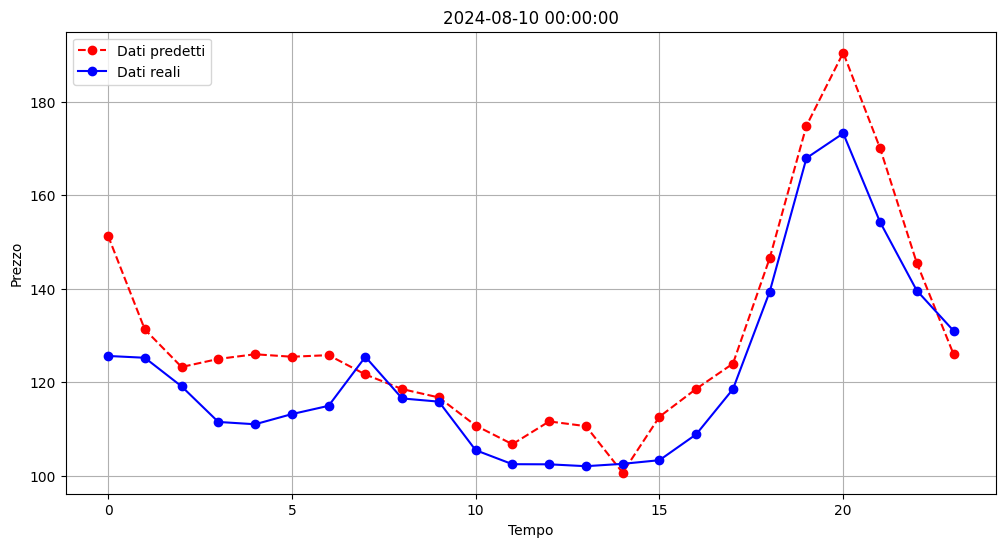

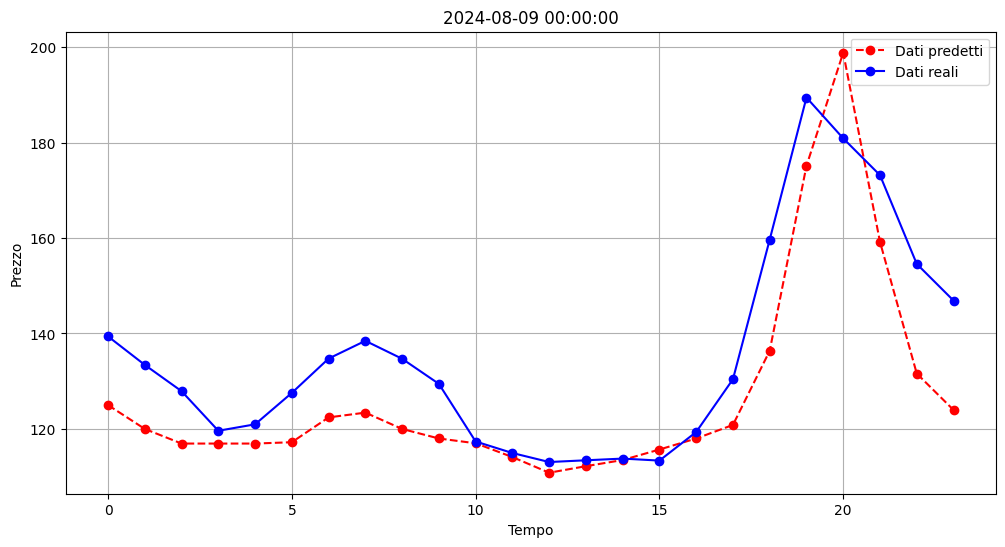

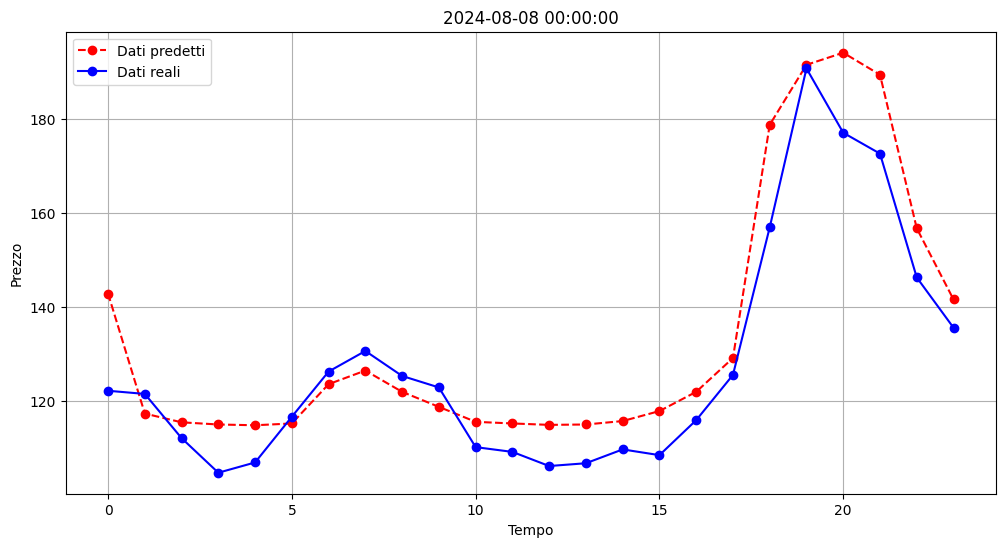

In [799]:
time_index = np.arange(24)

for i in range(20, 25):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test[-i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test_pred[-i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[-i])
    plt.grid(True)
    plt.show()

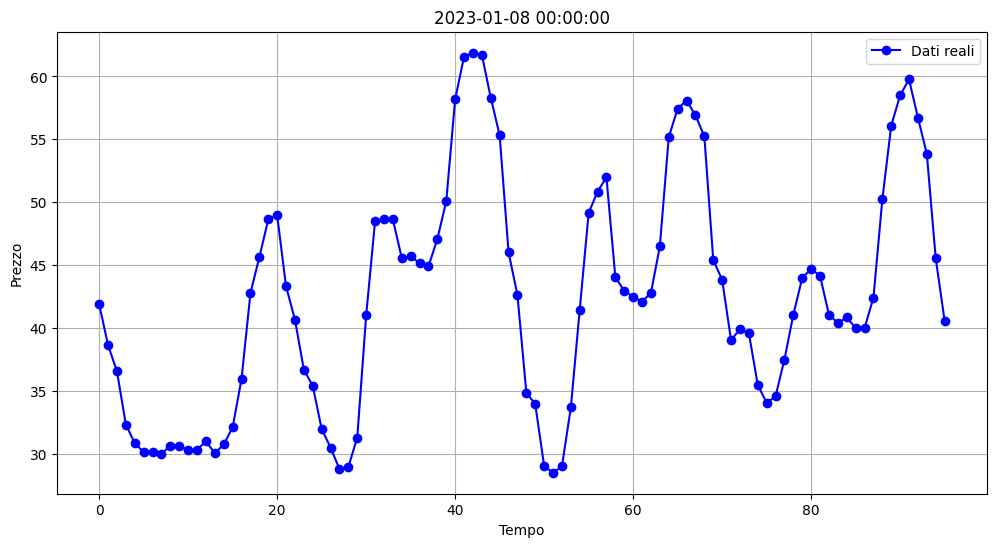

In [707]:
# PLOT DATI DI TRAIN
time_index = np.arange(24*4)

for i in range(0, 1):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, train_df['Price'].iloc[i:i+24*4], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[i])
    plt.grid(True)
    plt.show()

In [800]:
total_pred_days = X_test.shape[0]
total_train_days = X_train.shape[0]

total_train_days, total_pred_days

(1089, 602)

## Metrics computation

In [114]:
MAE_LEAR = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_LEAR = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_LEAR = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [115]:
MAE_LEAR, sMAPE_LEAR, MAPE_LEAR

(10.39883065556444, 0.10126435663374064, 0.1697444708379563)

## Adding dummy for DNN

In [806]:
dfTrain = deepcopy(train_df)
dfTest = deepcopy(test_df)

In [663]:
features = {'In: WorkingDay': 1,
 'In: Holiday' : 1,
 'In: Covid': 1,
 'In: Exog-1 D': 1,
 'In: Exog-1 D-1': 1,
 'In: Exog-1 D-7': 1,
 'In: Exog-2 D': 1,
 'In: Exog-2 D-1': 1,
 'In: Exog-2 D-7': 1,
 'In: Price D-1': 1,
 'In: Price D-2': 1,
 'In: Price D-3': 1,
 'In: Price D-7': 1,
 'activation': 'softplus',
 'batch_normalization': 1,
 'dropout': 0.8346876817795704,
 'init': 'glorot_uniform',
 'lambdal1': 0,
 'lr': 0.0027988003473657344,
 'neurons1': 225.0,
 'neurons2': 136.0,
 'reg': None,
 'scaleX': 'Median',
 'scaleY': 'Norm1',
 'seed': 396.0}

## INIZIO FUNZIONE

In [700]:
shuffle_train = True
hyperoptimization = True
percentage_val = 0.25
data_augmentation = False

In [665]:
if dfTrain.index[0].hour != 0 or dfTest.index[0].hour != 0:
    print('Problem with the index')

# Calculating the number of input features
n_features = features['In: WorkingDay'] + features['In: Holiday'] + features['In: Covid'] + \
    24 * features['In: Price D-1'] + 24 * features['In: Price D-2'] + \
    24 * features['In: Price D-3'] + 24 * features['In: Price D-7']

for n_ex in range(1, n_exogenous_inputs + 1):

    n_features += 24 * features['In: Exog-' + str(n_ex) + ' D'] + \
                    24 * features['In: Exog-' + str(n_ex) + ' D-1'] + \
                    24 * features['In: Exog-' + str(n_ex) + ' D-7']

In [666]:
indexTrain = dfTrain.loc[dfTrain.index[0] + pd.Timedelta(weeks=1):].index

In [667]:
indexTrain

DatetimeIndex(['2020-01-08 00:00:00', '2020-01-08 01:00:00',
               '2020-01-08 02:00:00', '2020-01-08 03:00:00',
               '2020-01-08 04:00:00', '2020-01-08 05:00:00',
               '2020-01-08 06:00:00', '2020-01-08 07:00:00',
               '2020-01-08 08:00:00', '2020-01-08 09:00:00',
               ...
               '2022-09-03 14:00:00', '2022-09-03 15:00:00',
               '2022-09-03 16:00:00', '2022-09-03 17:00:00',
               '2022-09-03 18:00:00', '2022-09-03 19:00:00',
               '2022-09-03 20:00:00', '2022-09-03 21:00:00',
               '2022-09-03 22:00:00', '2022-09-03 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=23280, freq=None)

In [668]:
if date_test is None:
    indexTest = dfTest.loc[dfTest.index[0] + pd.Timedelta(weeks=1):].index
else:
    indexTest = dfTest.loc[date_test:date_test + pd.Timedelta(hours=23)].index

In [669]:
# We extract the prediction dates/days. For the regular case, 
# it is just the index resample to 24 so we have a date per day.
# For the multiple datapoints per day, we have as many dates as indexs


if data_augmentation:
    predDatesTrain = indexTrain.round('1h')
else:
    predDatesTrain = indexTrain.round('1h')[::24]            
        
predDatesTest = indexTest.round('1h')[::24]

In [670]:
# We create dataframe where the index is the time where a prediction is made
# and the columns is the horizons of the prediction
indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
for hour in range(24):
    indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
    indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

In [671]:
# If we consider 24 predictions per day, the last 23 indexs cannot be used as there is not data
# for that horizon:
if data_augmentation:
    indexTrain = indexTrain.iloc[:-23]

In [672]:
# Preallocating in memory the X and Y arrays          
Xtrain = np.zeros([indexTrain.shape[0], n_features])
Xtest = np.zeros([indexTest.shape[0], n_features])
Ytrain = np.zeros([indexTrain.shape[0], 24])
Ytest = np.zeros([indexTest.shape[0], 24])

In [673]:
# Dummy 1
# Adding the working day/ non working day feature
working_days = [0, 1, 2, 3, 4]

indexFeatures = 0

# Giorno lavorativo -> valore unitario
if features['In: WorkingDay']:

    index_train = [working_day in working_days for working_day in indexTrain.index.dayofweek]
    index_test = [working_day in working_days for working_day in indexTest.index.dayofweek]
    Xtrain[index_train, 0] = 1
    Xtest[index_test, 0] = 1            
    indexFeatures += 1

In [674]:
# Dummy 2
# Aggiungiamo le holidays
if features['In: Holiday']:

        holidays_it = holidays.IT(years = [2020, 2021, 2022, 2023, 2024])

        holiday_dates = pd.to_datetime(list(holidays_it.keys()))
        
        Xtrain[indexTrain.index.isin(holiday_dates), indexFeatures] = 1
        Xtest[indexTest.index.isin(holiday_dates), indexFeatures] = 1
        indexFeatures += 1

In [675]:
# Dummy 3
# Aggiungiamo la presenza del Covid

if features['In: Covid']:

    data, _ = covid19dh.covid19(country="Italy", verbose=False, level=1)

    cols_to_retain = ["stay_home_restrictions"]

    data["date"] = data["date"].dt.date
    data.set_index("date", drop=True, inplace=True)
    data = data[cols_to_retain]

    # -2, 0, nan -> non ci sono restrizioni / 1, 2 -> restrizioni leggere, restrizioni pesanti

    covid_dates = pd.to_datetime(list(data[data['stay_home_restrictions'].isin([1, 2])].index))
    Xtrain[indexTrain.index.isin(covid_dates), indexFeatures] = 1
    Xtest[indexTest.index.isin(covid_dates), indexFeatures] = 1
    indexFeatures += 1


[-2.  2.  0.  1. nan]
----------------------------------------------------------------------------------------------------


In [676]:
# For each possible horizon
for hour in range(24):
    # For each possible past day where prices can be included
    for past_day in [1, 2, 3, 7]:

        # We define the corresponding past time indexs 
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
            pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
            pd.Timedelta(hours=24 * past_day)

        # We include feature if feature selection indicates it
        if features['In: Price D-' + str(past_day)]:
            Xtrain[:, indexFeatures] = dfTrain.loc[pastIndexTrain, 'Price']
            Xtest[:, indexFeatures] = dfTest.loc[pastIndexTest, 'Price']
            indexFeatures += 1

In [478]:
# 97

In [677]:
# For each possible horizon
for hour in range(24):
    # For each possible past day where exogeneous can be included
    for past_day in [1, 7]:

        # We define the corresponding past time indexs 
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
            pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
            pd.Timedelta(hours=24 * past_day)

        # For each of the exogenous inputs we include feature if feature selection indicates it
        for exog in range(1, n_exogenous_inputs + 1):
            if features['In: Exog-' + str(exog) + ' D-' + str(past_day)]:
                Xtrain[:, indexFeatures] = dfTrain.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
                Xtest[:, indexFeatures] = dfTest.loc[pastIndexTest, 'Exogenous ' + str(exog)]
                indexFeatures += 1

In [398]:
# 193


241

In [678]:
# For each of the exogenous inputs we include feature if feature selection indicates it
for hour in range(24):
    for exog in range(1, n_exogenous_inputs + 1):
        # Adding exogenous inputs at day D
        if features['In: Exog-' + str(exog) + ' D']:
            futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
            futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

            Xtrain[:, indexFeatures] = dfTrain.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
            Xtest[:, indexFeatures] = dfTest.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
            indexFeatures += 1

In [679]:
# Extracting the predicted values Y
for hour in range(24):
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    Ytrain[:, hour] = dfTrain.loc[futureIndexTrain, 'Price']        
    Ytest[:, hour] = dfTest.loc[futureIndexTest, 'Price'] 

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [680]:

if shuffle_train:
    nVal = int(percentage_val * Xtrain.shape[0])

    if hyperoptimization:
        # We fixed the random shuffle index so that the validation dataset does not change during the
        # hyperparameter optimization process
        np.random.seed(7)

    # We shuffle the data per week to avoid data contamination
    index = np.arange(Xtrain.shape[0])
    index_week = index[::7]
    np.random.shuffle(index_week)
    index_shuffle = [ind + i for ind in index_week for i in range(7) if ind + i in index]

    Xtrain = Xtrain[index_shuffle]
    Ytrain = Ytrain[index_shuffle]

else:
    nVal = int(percentage_val * Xtrain.shape[0])
nTrain = Xtrain.shape[0] - nVal # complements nVal

Xval = Xtrain[nTrain:] # last nVal obs
Xtrain = Xtrain[:nTrain] # first nTrain obs
Yval = Ytrain[nTrain:]
Ytrain = Ytrain[:nTrain]

## FINE FUNZIONE

In [808]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs_customized(dfTrain=train_df,dfTest=test_df,  features=features, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

# DNN model

In [452]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"
train_df, test_df = read_data(path, dataset = "IT") # Grouped dataframes (by date)

In [156]:
# features = {}
# for key in list(opt_hyperparams.keys())[0:11]:
#     features[key] = 1

In [157]:
# NOTA: si consiglia di utilizzare almeno un anno di test

# train_years = 2
# test_years = 1
# train_df = train_df.iloc[-365*train_years*24:, :]
# test_df = test_df.iloc[:round(365*test_years)*24, :]

In [158]:
# X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
#     _build_and_split_XYs(dfTrain=train_df,dfTest=test_df,  features=features, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
#                         date_test=None, hyperoptimization=True, data_augmentation=False)

In [809]:
X_train = deepcopy(Xtrain)
Y_train = deepcopy(Ytrain)
X_val = deepcopy(Xval)
Y_val = deepcopy(Yval)
X_test = deepcopy(Xtest)
Y_test = deepcopy(Ytest)

In [702]:
# Pre- allochiamo la memoria per i valori di X e Y normalizzati

X_train_norm = np.zeros((X_train.shape[0], X_train.shape[1]))
X_val_norm = np.zeros((X_val.shape[0], X_val.shape[1]))
X_test_norm = np.zeros((X_test.shape[0], X_test.shape[1]))

# Associamo alla prima colonna i valori 0/1 per giorni feriali/festivi
X_train_norm[:, 0:3 ] = X_train[:, 0:3]
X_val_norm[:, 0:3] = X_val[:, 0:3]
X_test_norm[:, 0:3] = X_test[:, 0:3]

# Per tutte le altre colonne facciamo una normalizzazione column - based 
for i in range(X_train.shape[1] - 3):
    scaler_x = StandardScaler()
    scaler_x.fit(X_train[:, i+3].reshape(-1, 1))
    X_train_norm[:, i+3] = scaler_x.transform(X_train[:, i+3].reshape(-1, 1)).reshape(-1)
    X_val_norm[:, i+3] = scaler_x.transform(X_val[:, i+3].reshape(-1, 1)).reshape(- 1)
    X_test_norm[:, i+3] = scaler_x.transform(X_test[:, i+3].reshape(-1, 1)).reshape(-1)

# Scaliamo i valori di y
scaler_y = StandardScaler()
scaler_y.fit(Y_train)
Y_train_norm = scaler_y.transform(Y_train)
Y_val_norm = scaler_y.transform(Y_val)

In [810]:
X_train_norm, Y_train_norm, X_val_norm, Y_val_norm, X_test_norm , scaler_y = rescale(X_train, Y_train, X_val, Y_val, X_test)

In [490]:
# In questo caso lo scaling è effettuato normalizzando i dati rispetto alla norma-2
from epftoolbox.data import DataScaler
from sklearn.preprocessing import StandardScaler


# scaler_x = StandardScaler()

# X_train_norm = np.zeros((X_train.shape[0], X_train.shape[1]))
# X_train_norm[:, 0] = X_train[:, 0]
# scaler_x.fit(X_train[:, 1:])
# X_train_norm[:, 1:] = scaler_x.transform(X_train[:, 1:])

# X_val_norm = np.zeros((X_val.shape[0], X_val.shape[1]))
# X_val_norm[:, 0] = X_val[:, 0]
# X_val_norm[:, 1:] = scaler_x.transform(X_val[:, 1:])

# X_test_norm = np.zeros((X_test.shape[0], X_test.shape[1]))
# X_test_norm[:, 0] = X_test[:, 0]
# X_test_norm[:, 1:] = scaler_x.transform(X_test_norm[:, 1:])

# scaler_y = StandardScaler()
# scaler_y.fit(Y_train)
# Y_train_norm = scaler_y.transform(Y_train)
# Y_val_norm = scaler_y.transform(Y_val)

In [420]:
pd.DataFrame(X_train).iloc[:, 0]

0      1.0
1      1.0
2      1.0
3      0.0
4      0.0
      ... 
723    1.0
724    1.0
725    1.0
726    1.0
727    1.0
Name: 0, Length: 728, dtype: float64

In [811]:
neurons = [150, 150]
n_features = X_train.shape[1]
dropout = 0.5

# Scaler = None perchè normalizziamo noi prima
# Lamba_reg è il termine di regolarizzazione -> l1 o l2 ma i risultati migliori si ottengono senza

model_dnn = DNNModel(neurons=neurons, n_features= n_features, dropout=dropout, batch_normalization=False, scaler=None, lambda_reg=None, lr=0.003)

In [812]:
model_dnn.fit(X_train_norm, Y_train_norm, X_val_norm, Y_val_norm)

In [813]:
Y_test_pred_norm = model_dnn.predict(X_test_norm)

In [814]:
# Riportiamo i dati predetti alla scala reale
Y_test_pred = scaler_y.inverse_transform(Y_test_pred_norm)

In [815]:
Y_test_pred

array([[379.19098, 359.22775, 350.5624 , ..., 430.59134, 402.14194,
        379.296  ],
       [383.96405, 359.23126, 349.943  , ..., 460.238  , 426.42535,
        400.4976 ],
       [391.25864, 360.9873 , 351.42358, ..., 464.29877, 432.16516,
        406.18463],
       ...,
       [142.49013, 136.09818, 132.4803 , ..., 158.58379, 150.08029,
        142.15007],
       [152.85788, 145.89487, 142.29665, ..., 171.73352, 162.45723,
        153.60603],
       [142.12845, 135.89989, 132.3189 , ..., 155.80084, 148.00427,
        140.61127]], dtype=float32)

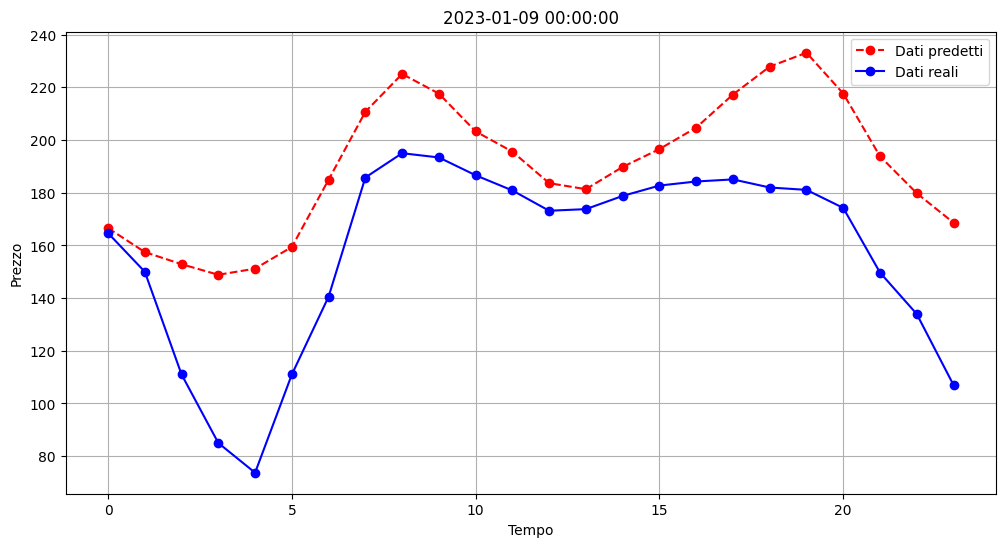

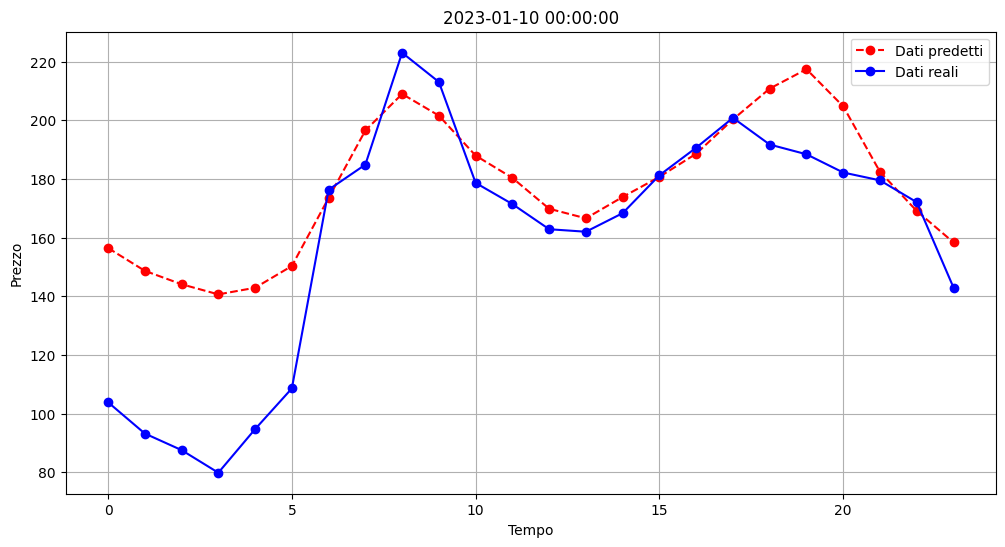

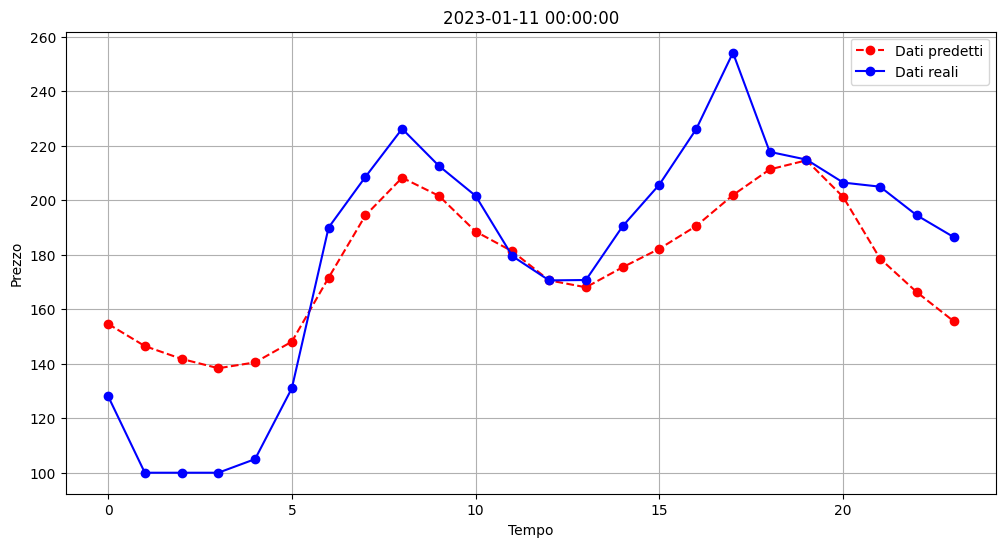

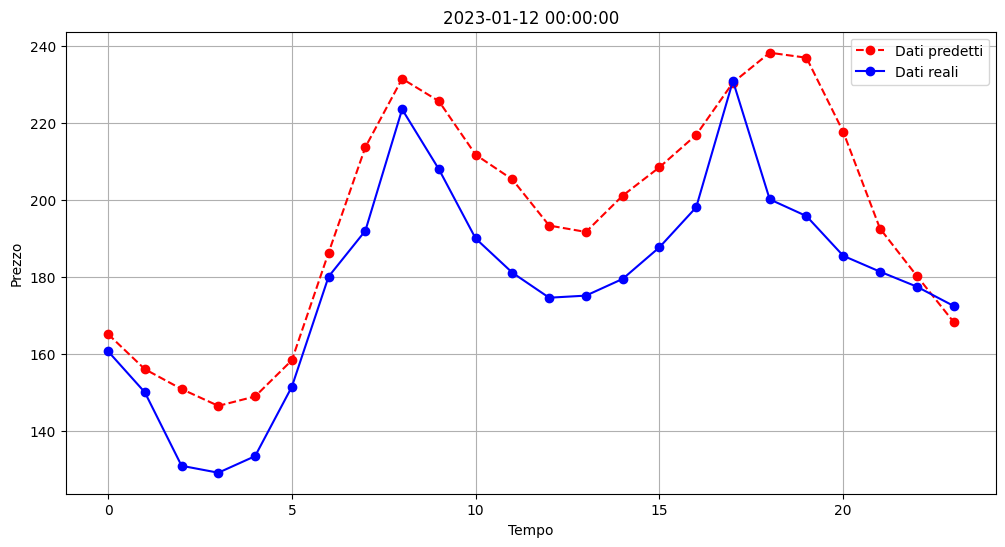

In [65]:
time_index = np.arange(24)

for i in range(1, 5):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[i]))
    plt.grid(True)
    plt.show()

### Metrics computation

In [817]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(np.array(Y_test_pred))) 
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(np.array(Y_test_pred))) 
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(np.array(Y_test_pred)))

In [818]:
MAE_DNN, sMAPE_DNN, MAPE_DNN

(20.017406419686342, 0.1489109844016231, 0.2528284941058706)

In [736]:
total_train_days = X_train.shape[0] + X_val.shape[0]
total_pred_days = X_test.shape[0] 

total_train_days, total_pred_days

(970, 721)

In [802]:
1089 + 602, 970 + 721

(1691, 1691)

In [805]:
indexTrain.index[0:1069]
indexTest.index

DatetimeIndex(['2023-01-08', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13', '2023-01-14', '2023-01-15',
               '2023-01-16', '2023-01-17',
               ...
               '2024-08-22', '2024-08-23', '2024-08-24', '2024-08-25',
               '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29',
               '2024-08-30', '2024-08-31'],
              dtype='datetime64[ns]', name='Date', length=602, freq=None)

## Ottimizzazione iperparametri

In [40]:
path_dataset = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"
test_start_date = pd.to_datetime('2023-01-01 00:00:00')
test_end_date = pd.to_datetime('2024-08-31 23:00:00')

In [41]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = 'IT'

# Number of years (a year is 364 days) in the test dataset.
years_test = len(test_df)/364

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = test_start_date
end_test_date = test_end_date

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = len(train_df)/364

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 10

path_datasets_folder = path_dataset
path_hyperparameters_folder = path +  "/experimental_files/"

In [42]:
# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer_customized(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2023-01-01 00:00:00 - 2024-08-31 23:00:00



c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 1/10 iterations.
Best MAE - Validation Dataset
  MAE: 143.7 | sMAPE: 171.27 %

Best MAE - Test Dataset
  MAE: 110.7 | sMAPE: 181.43 %




Tested 2/10 iterations.
Best MAE - Validation Dataset
  MAE: 20.3 | sMAPE: 16.23 %

Best MAE - Test Dataset
  MAE: 12.9 | sMAPE: 12.43 %




Tested 3/10 iterations.
Best MAE - Validation Dataset
  MAE: 20.3 | sMAPE: 16.23 %

Best MAE - Test Dataset
  MAE: 12.9 | sMAPE: 12.43 %




Tested 4/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %




Tested 5/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %




Tested 6/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 7/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %




Tested 8/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %




Tested 9/10 iterations.
Best MAE - Validation Dataset
  MAE: 16.2 | sMAPE: 12.86 %

Best MAE - Test Dataset
  MAE: 13.6 | sMAPE: 12.66 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]


In [43]:
import pickle as pc

# Percorso dove è stato salvato il file di ottimizzazione
trials_file_path = os.path.join(path_hyperparameters_folder, 'DNN_hyperparameters_nl' + str(nlayers) +
                                '_dat' + str(dataset) + '_YT' + str(years_test) + 
                                '_SF' * shuffle_train + '_DA' * data_augmentation + 
                                '_CW' + str(calibration_window) + '_' + str(experiment_id))

# Caricare il file di trials salvato
with open(trials_file_path, "rb") as f:
    trials = pc.load(f)

In [46]:
# Miglior risultato dato dall'ottimizzatore
best_trial = trials.best_trial

In [47]:
# Questa funzione del toolbox mette in automatico i parametri di ottimizzazione nel formato richiesto (dizionario) per il modello
opt_hyperparams = format_best_trial(best_trial)

In [59]:
# Metodo per passare da dataframe a dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs_customized(dfTrain=train_df,dfTest=test_df,  features=opt_hyperparams, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

In [60]:
model = DNN(experiment_id=1, path_hyperparameter_folder=path_hyperparameters_folder, nlayers=2,
            dataset='IT', years_test=years_test, shuffle_train=1, data_augmentation=0, calibration_window=calibration_window) 

In [61]:
X_train_reg, X_val_reg, X_test_reg, Y_train_reg, Y_val_reg = model._regularize_data(X_train, X_val, X_test, Y_train, Y_val)

In [62]:
model.recalibrate(X_train_reg, Y_train_reg, X_val_reg, Y_val_reg)

In [63]:
Y_test_pred = model.predict(X_test_reg)

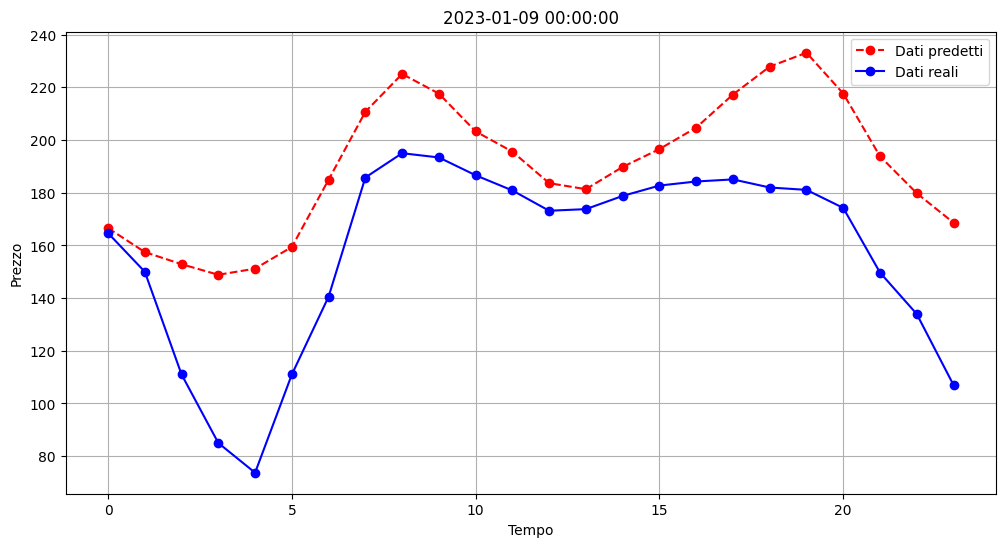

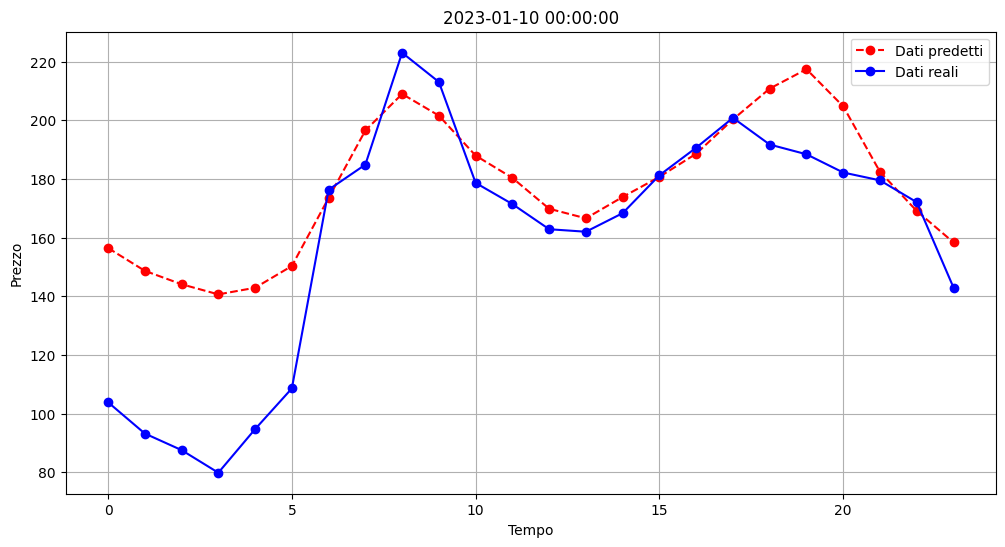

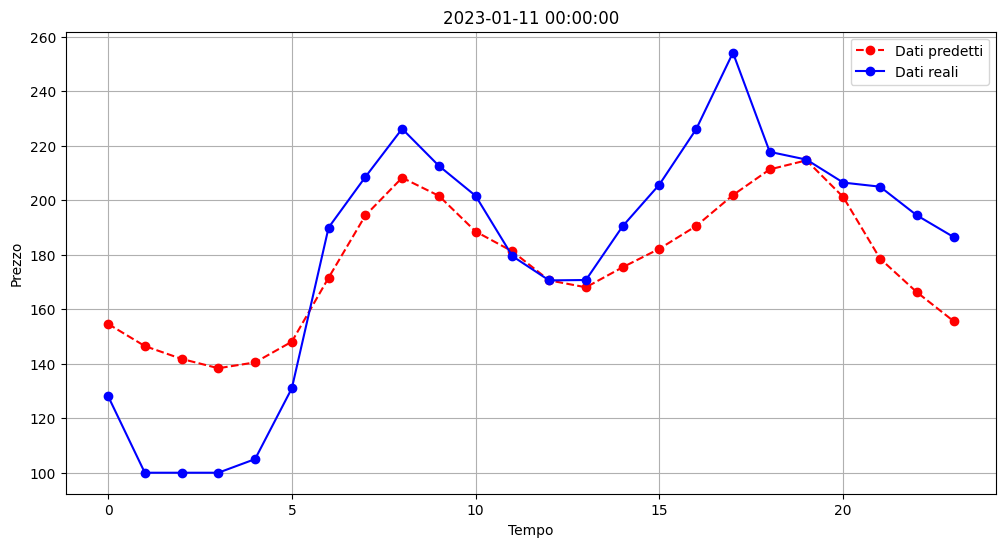

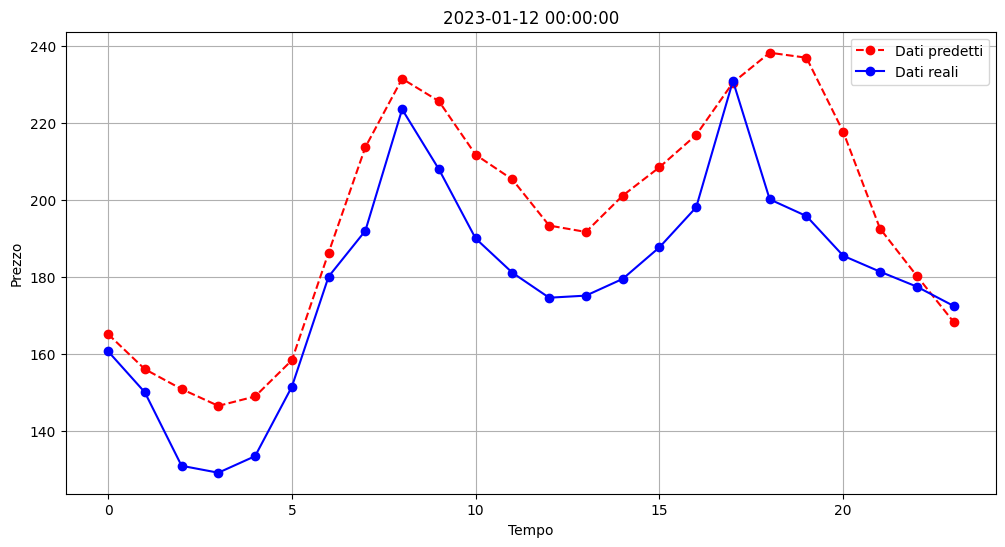

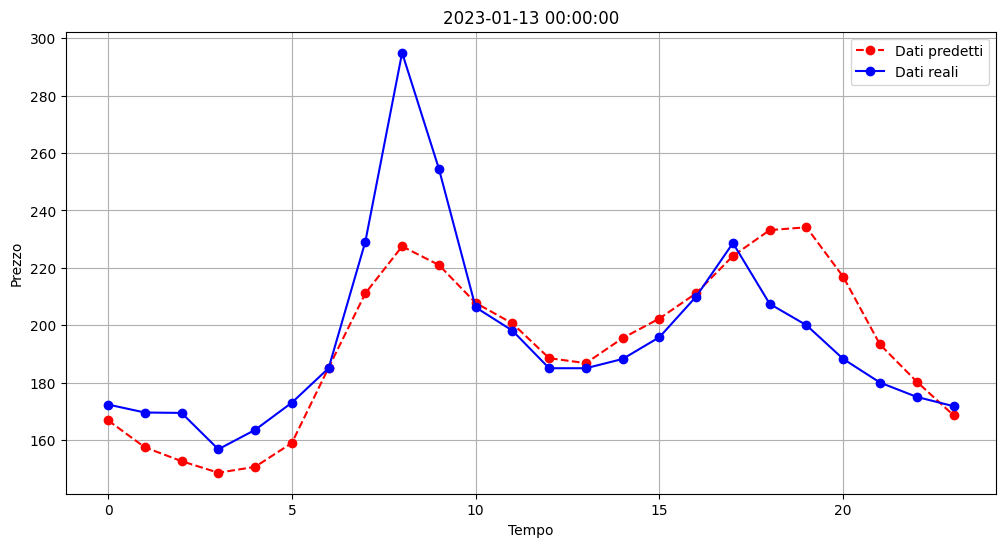

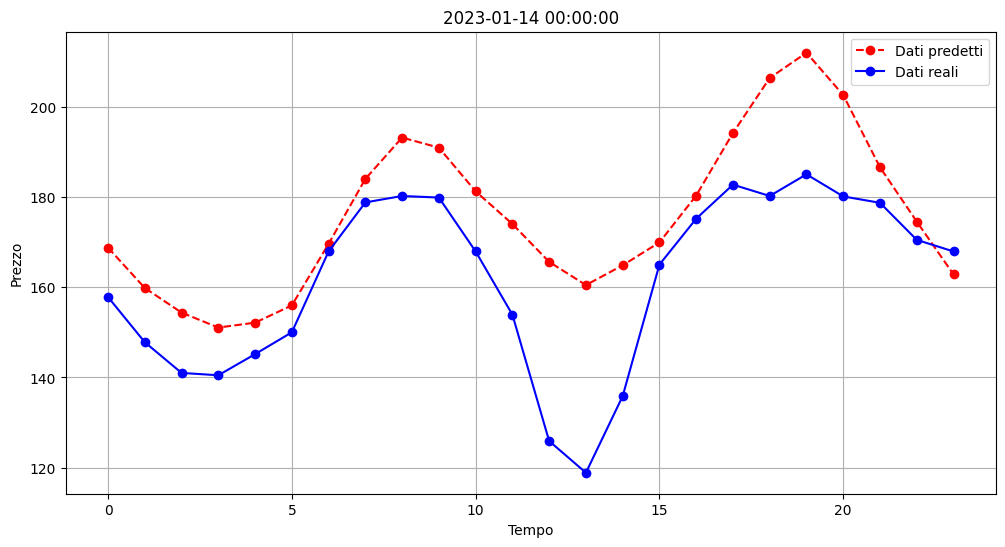

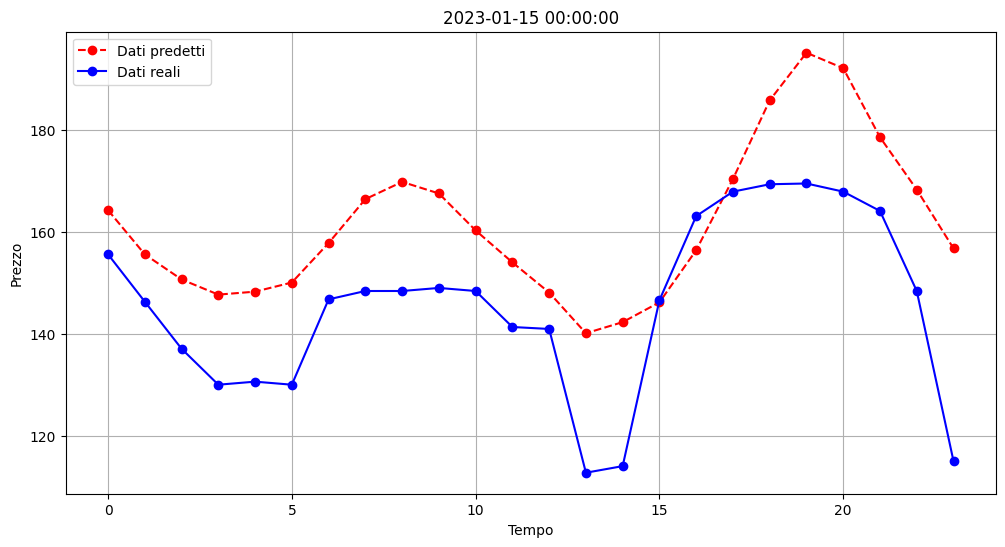

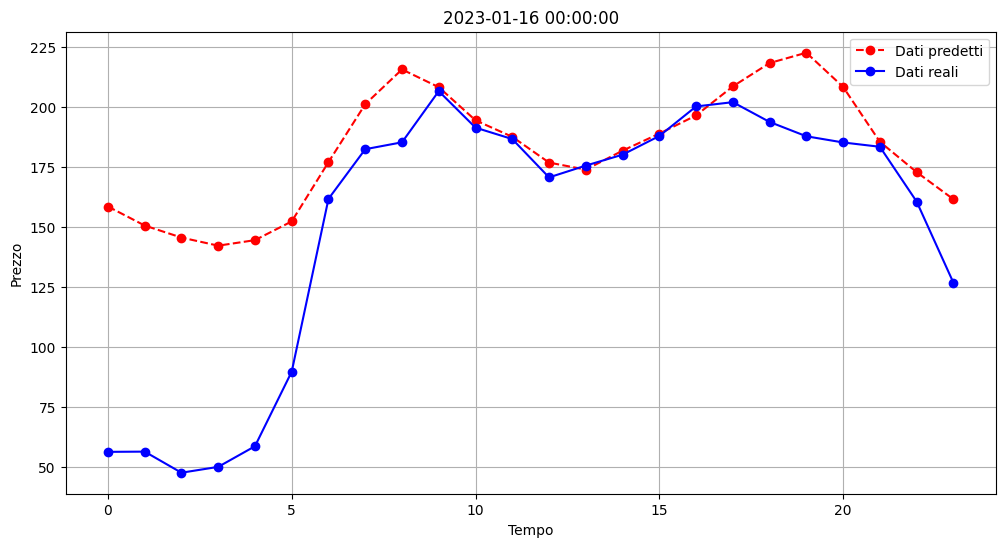

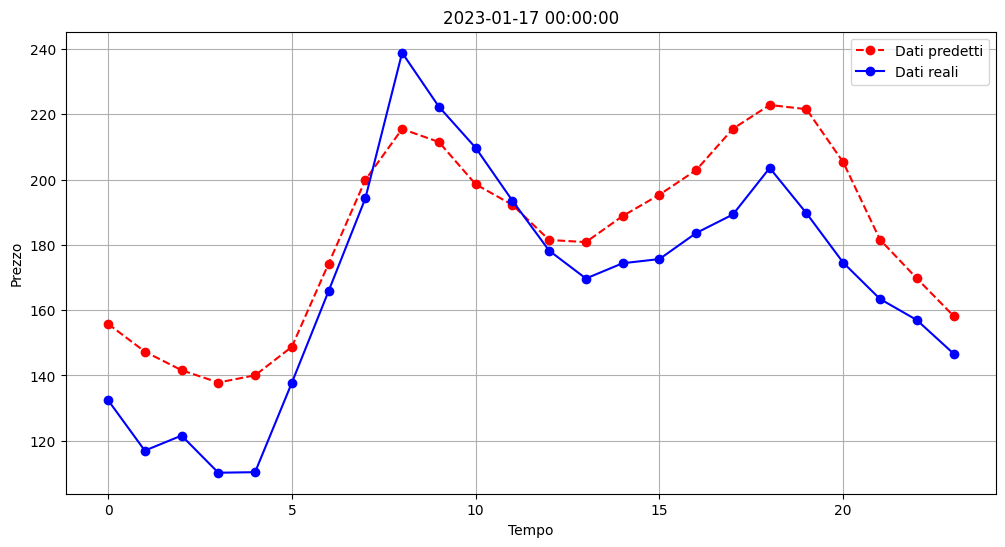

In [73]:
time_index = np.arange(24)


for i in range(1, 10):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[i]))
    plt.grid(True)
    plt.show()

### Metrics computation

In [70]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [71]:
MAE_DNN, sMAPE_DNN, MAPE_DNN

(13.595492244315668, 0.1259013849065462, 0.23757331661896852)